In [1]:
import math
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Arc
from svgpath2mpl import parse_path
from common import Fonts, Images, NWSL, Colors, add_twitter_handle, add_source

In [2]:
d = "M480 975q-140-35-230-162.5T160 533V295l320-120 320 120v238q0 152-90 279.5T480 975Zm0-62q115-38 187.5-143.5T740 533V337l-260-98-260 98v196q0 131 72.5 236.5T480 913Zm0-337Z"
path = parse_path(d)
path = path.transformed(mpl.transforms.Affine2D().translate(-500, -600).rotate_deg(180))

In [3]:
champions = {
    2013: "POR",
    2014: "KC",
    2015: "KC",
    2016: "WNY",
    2017: "POR",
    2018: "NC",
    2019: "NC",
    2021: "WAS",
    2022: "POR"
}
shield = {
    2013: "WNY",
    2014: "RGN",
    2015: "RGN",
    2016: "POR",
    2017: "NC",
    2018: "NC",
    2019: "NC",
    2021: "POR",
    2022: "RGN"
}

In [10]:
team = "RGN"
df = pd.read_csv("data/" + team + "_reg_matches.csv")
df = df.sort_values("date", ascending=False).reset_index(drop=True)
df

,date,season,team_score,opp_score,result
0,2023-04-22,2023,5,2,W
1,2023-04-15,2023,1,0,W
2,2023-04-01,2023,2,0,W
3,2023-03-26,2023,0,1,L
4,2022-10-01,2022,3,0,W
...,...,...,...,...,...
203,2013-05-11,2013,0,2,L
204,2013-05-04,2013,0,1,L
205,2013-04-26,2013,0,2,L
206,2013-04-21,2013,1,2,L


In [11]:
# Calculate the number of wins, losses, and ties
counts = df.groupby("result").agg({"result": "count"}).T.to_dict("records")[0]
counts

{'D': 52, 'L': 57, 'W': 99}

<ipython-input-13-58b7c68db63f>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


<Figure size 432x432 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

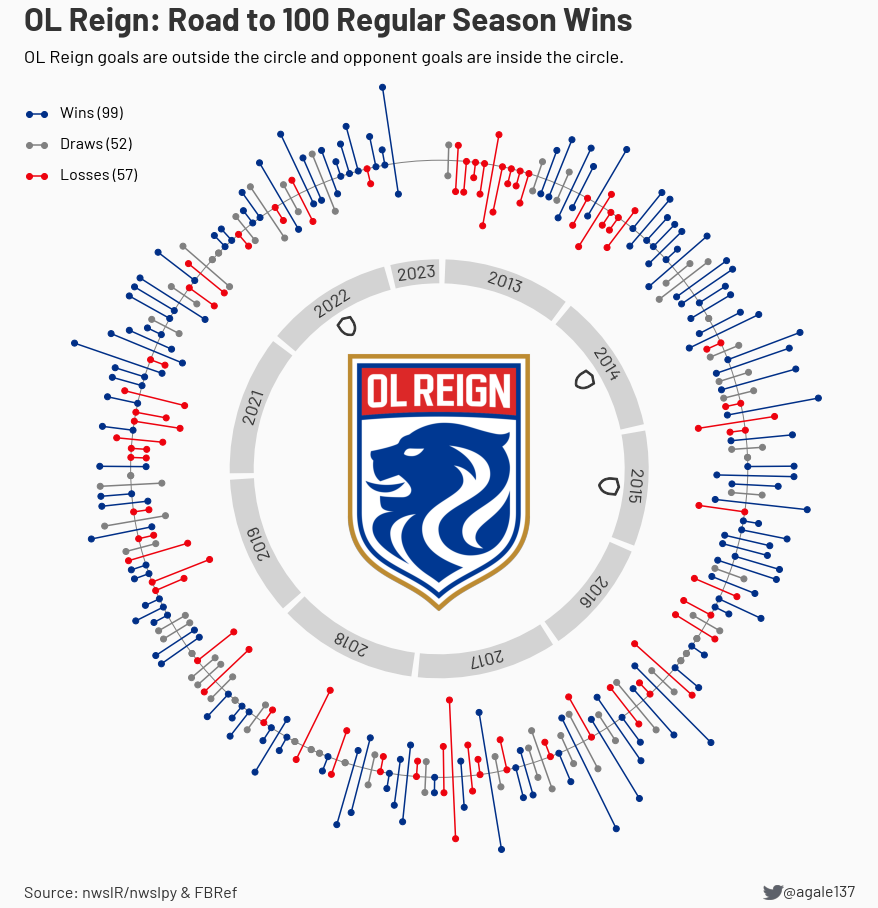

In [13]:
# Constants

TEAM_COLORS = {
    "POR": {"W": "#004812", "D": "gray", "L": "#99242C"},
    "RGN": {"W": "#002f87", "D": "gray", "L": "#ed020e"},
    "CHI": {"W": "#60BDEA", "D": "gray", "L": "#C8102E"},
}
COLORS = TEAM_COLORS[team]


n = len(df.index)
# Adjust to leave space for 2023 games
padding = 5  # 22 - len(df[df["season"] == 2023].index)
n = n + padding


def rads(i):
    return (i + padding) / n * (math.pi * 2) + math.pi / 2


def degs(i):
    return (i + padding) / n * 360 + 90


# Draw the plot
plt.clf()
plt.rcParams["figure.figsize"] = (6, 6)
plt.figure(dpi=200)
fig, ax = plt.subplots()
ax.axis("off")
ax = fig.add_axes([-1, -1, 2, 2])
fig.tight_layout()
fig.patch.set_facecolor(Colors.WHITE)
ax.set_facecolor(Colors.WHITE)
ax.axis("off")
ax.set_aspect("equal", "datalim")

x = []
y = []
c = []
segs = []
segs_c = []
# Generate datapoints
for i, row in df.iterrows():
    angle = rads(i)
    color = COLORS[row["result"]]
    # Team score
    team_r = 1 + row["team_score"] * 0.05
    x.append(team_r * math.cos(angle))
    y.append(team_r * math.sin(angle))
    c.append(color)
    # Opp score
    opp_r = 1 - row["opp_score"] * 0.05
    x.append(opp_r * math.cos(angle))
    y.append(opp_r * math.sin(angle))
    c.append(color)

    segs.append([(x[-2], y[-2]), (x[-1], y[-1])])
    segs_c.append(color)

# Plot background circle
ax.add_patch(plt.Circle((0, 0), 1, ec=Colors.GRAY, fc=Colors.WHITE))
ax.set_xlim([-1.4, 1.4])
ax.set_ylim([-1.4, 1.4])

# Plot lines
line_segments = LineCollection(segs, color=segs_c)
ax.add_collection(line_segments)

# Plot points
plt.scatter(x, y, c=c)

# Legend
pos = (-1.33, 1.15)
h = 0.1
entries = [("Wins", COLORS["W"]), ("Draws", COLORS["D"]), ("Losses", COLORS["L"])]
for i, (label, color) in enumerate(entries):
    plt.scatter([pos[0], pos[0] + 0.05], [pos[1] - h * i, pos[1] - h * i], c=color)
    ax.add_collection(
        LineCollection(
            [[(pos[0], pos[1] - h * i), (pos[0] + 0.05, pos[1] - h * i)]], color=color
        )
    )
    ax.text(
        pos[0] + 0.1,
        pos[1] - h * i,
        label + " (" + str(counts[label[0]]) + ")",
        fontproperties=Fonts.BARLOW,
        size=16,
        ha="left",
        va="center",
    )

# Season labels
season_r = 0.64
for season in df["season"].unique():
    games = df[df["season"] == season].index
    i_a = games[0] if season != 2023 else len(df.index) - n
    i_b = games[-1]
    a = degs(i_a)
    b = degs(i_b)

    ax.add_patch(
        Arc(
            (0, 0),
            season_r * 2,
            season_r * 2,
            theta1=a,
            theta2=b,
            color=Colors.LIGHT_GRAY,
            lw=24,
        )
    )
    angle = rads((i_a + i_b) / 2)
    adjusted_r = season_r - 0.009
    ax.text(
        adjusted_r * math.cos(angle),
        adjusted_r * math.sin(angle) + 0.006,
        str(season),
        ha="center",
        va="center",
        size=18,
        fontproperties=Fonts.BARLOW,
        color=Colors.BLACK,
        rotation=(a + b) / 2 - 90,
    )

    if season in champions and champions[season] == team:
        star_r = adjusted_r * 0.87
        plt.scatter(
            star_r * math.cos(angle),
            star_r * math.sin(angle),
            c=Colors.BLACK,
            marker="*",
            s=54,
        )
    if season in shield and shield[season] == team:
        shield_r = adjusted_r * 0.87
        shield_path = path.transformed(mpl.transforms.Affine2D().rotate_deg((a + b) / 2 - 90))
        plt.scatter(
            shield_r * math.cos(angle),
            shield_r * math.sin(angle),
            c=Colors.BLACK,
            marker=shield_path,
            s=500,
        )

# Title
plt.title(
    NWSL.name(team) + ": Road to 100 Regular Season Wins",
    fontproperties=Fonts.BARLOW_BOLD,
    size=32,
    x=0.02,
    y=1,
    ha="left",
    color=Colors.BLACK,
)

# Subtitle
ax.text(
    0.02,
    0.97,
    NWSL.name(team)
    + " goals are outside the circle and opponent goals are inside the circle.",
    fontproperties=Fonts.BARLOW,
    size=18,
    ha="left",
    transform=ax.transAxes,
)

# Add team logo
logo_w = 0.7 if team == "POR" else 0.62
y_offset = -0.03 if team in ["RGN", "CHI"] else 0
logo_ax = fig.add_axes([-logo_w / 2, -logo_w / 2 + y_offset, logo_w, logo_w])
logo_ax.imshow(plt.imread("logos/" + team + "_logo.png"))
logo_ax.axis("off")

add_twitter_handle(fig, x=0.75, y=-1, fs=16, w=0.04)
add_source(fig, "nwslR/nwslpy & FBRef", fs=16, x=-0.96, y=-1)

# Save image
plt.savefig(
    "images/" + team + "_road_to_100.png", bbox_inches="tight", pad_inches=0.5, dpi=400
)